# Лабораторная №4

In [6]:
from IPython.display import Image
from io import StringIO
import graphviz
import pydotplus
from sklearn.tree import export_graphviz

import numpy as np
import pandas as pd
import math

import seaborn as sns
sns.set(style="ticks")

import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error

In [2]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.2, a-0.1, str(round(b,3)), color='white')
        plt.show()    

In [3]:
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [4]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

In [7]:
data = pd.read_csv("forestfires.csv")

## Предобработка данных

In [5]:
data.head()

X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [7]:
data.describe()

X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.600000  108.300000  664.200000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   10.800000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain         area  
count  517.000000  517.000000  517.000000  517.000000   517.000000  
mean    18.889168   44.288201    4.017602    0.021663    12.847292  
std      5.806625   16.317469    1.791653    0.295959    63.655818  
min      2.200000   15.000000    0.400000    0.000000     0.000000  
25%     15.500000   33.000000    2.700000    0.000000     0.000000  
50%     19.300000   42.000000    4.000000    0.000000     0.520000  
75%     22.800000   53.000000    4.900000    0.000000     6.570000  
max     33.300000  100.000000    9.400000    6.400000  1090.840000

Закодируем категориальные признаки

In [17]:
total_count = data.shape[0]
num_cols = []
for col in data.columns: 
    dt = str(data[col].dtype)
    if (dt=='object'):
        num_cols.append(col)        
        print('Колонка {}. Количество категорий: {}'.format(col, data[col].unique().shape[0]))

Колонка month. Количество категорий: 12
Колонка day. Количество категорий: 7


Площадь выжженого леса вряд ли зависит от дня недели

In [8]:
data = data.drop(['day'], axis = 1)

Будем использовать OneHotEncoder

In [9]:
categorical = ['month']

data = pd.concat([data, pd.get_dummies(data[categorical], columns=categorical, drop_first=True)],axis=1)
data.drop(categorical, axis=1, inplace=True)

Рассмотрим area

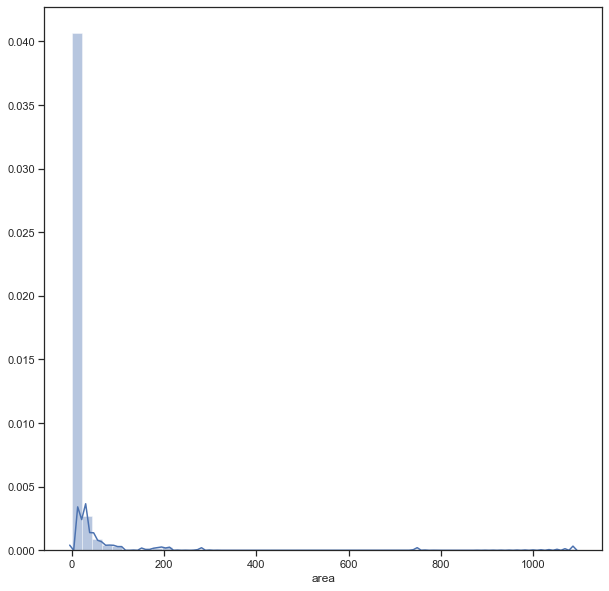

In [36]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.distplot(data['area'])

Зависимая переменная сильно искажена с большим количеством нулевых значений и строго положительна. В дальнейшем лучше будем рассматривать логарифм от выжженной территории.

In [10]:
data['logarea'] = [math.log(data['area'][i]) if data['area'][i] > 0 else 0 for i in range(len(data['area']))]

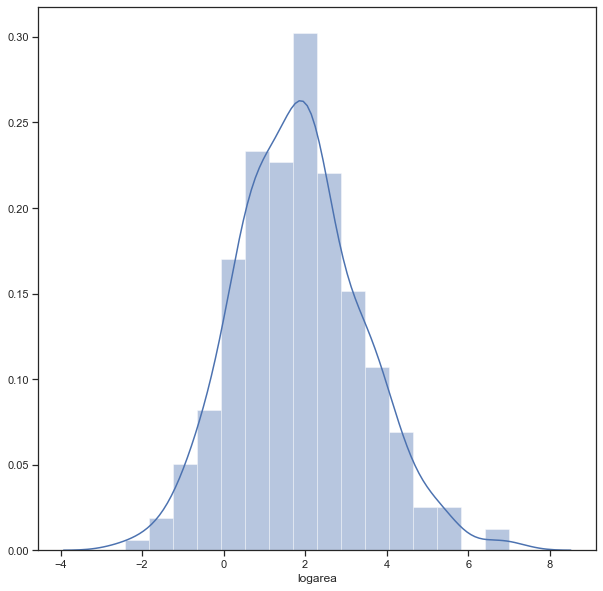

In [106]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.distplot(data['logarea'])

Теперь данные примерно нормально распределены

In [11]:
data = data.drop(['area'], axis = 1)

In [12]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
data[:] = min_max_scaler.fit_transform(data)

Разделим выборку на обучающую и тестовую

In [13]:
%%capture
y = data['logarea']
data = data.drop(['logarea'], axis = 1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=23)

In [15]:
metrics = MetricLogger()

In [18]:
models = {'LR': LinearRegression(), 
               'KNN_5':KNeighborsRegressor(n_neighbors=5),
               'SVR':SVR(),
               'Tree':DecisionTreeRegressor(),
               'RF':RandomForestRegressor(),
               'EF':ExtraTreesRegressor(),
               'GB':GradientBoostingRegressor()}

In [21]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, Y_pred)
    mse = mean_squared_error(y_test, Y_pred)
    r2 = r2_score(y_test, Y_pred)
    median = median_absolute_error(y_test, Y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    metrics.add('Median', model_name, median)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('{} \t MAE={}, MSE={}, R2={}, Median={}'.format(
        model_name, round(mae, 3), round(mse, 3), round(r2, 3), round(median, 3)))

In [22]:
for model_name, model in models.items():
    regr_train_model(model_name, model, metrics)

LR 	 MAE=0.127, MSE=0.026, R2=-0.128, Median=0.102
KNN_5 	 MAE=0.135, MSE=0.03, R2=-0.289, Median=0.112
SVR 	 MAE=0.126, MSE=0.023, R2=-0.009, Median=0.103
Tree 	 MAE=0.156, MSE=0.05, R2=-1.161, Median=0.105
RF 	 MAE=0.132, MSE=0.027, R2=-0.194, Median=0.101
EF 	 MAE=0.13, MSE=0.028, R2=-0.213, Median=0.102
GB 	 MAE=0.132, MSE=0.027, R2=-0.187, Median=0.124


In [28]:
from sklearn.model_selection import GridSearchCV

In [31]:
n_range = np.array(range(1,50,1))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
         35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])}]

In [32]:
%%time
regr_gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(X_train, y_train)

CPU times: user 976 ms, sys: 3.89 ms, total: 980 ms
Wall time: 978 ms


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])}],
             scoring='neg_mean_squared_error')

In [33]:
regr_gs.best_params_, regr_gs.best_score_

({'n_neighbors': 42}, -0.023604022166245766)

## Линейная модель

In [59]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [60]:
y_pred_linear = model.predict(X_test)

RMSE = mean_squared_error(y_test, y_pred_linear, squared=False)
MAE = mean_absolute_error(y_test, y_pred_linear)
R2_Score = r2_score(y_test, y_pred_linear)
MedAE = median_absolute_error(y_test, y_pred_linear)

metrics.add('RMSE', 'Linear Regression', RMSE)
metrics.add('MAE', 'Linear Regression', MAE)
metrics.add('R2 Score', 'Linear Regression', R2_Score)
metrics.add('Median AE', 'Linear Regression', MedAE)

print('RMSE =', RMSE)
print('MAE =', MAE)
print('R2 Score =', R2_Score)
print ("Median AE =", MedAE) # 0 - лучшее значение

RMSE = 0.16111015783482469
MAE = 0.12726750785767615
R2 Score = -0.12830661154862666
Median AE = 0.10177245400770207


In [71]:
from sklearn.linear_model import Ridge

model = Ridge(alpha = 5)
model.fit(X_train, y_train)

Ridge(alpha=5)

In [72]:
y_pred_ridge = model.predict(X_test)

RMSE = mean_squared_error(y_test, y_pred_linear, squared=False)
MAE = mean_absolute_error(y_test, y_pred_linear)
R2_Score = r2_score(y_test, y_pred_linear)
MedAE = median_absolute_error(y_test, y_pred_linear)

print('RMSE =', RMSE)
print('MAE =', MAE)
print('R2 Score =', R2_Score)
print ("Median AE =", MedAE) # 0 - лучшее значение

RMSE = 0.16111015783482469
MAE = 0.12726750785767615
R2 Score = -0.12830661154862666
Median AE = 0.10177245400770207


## SVM

In [61]:
svr = SVR(kernel='rbf', gamma=0.001, C=1000.0)
svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

In [62]:
RMSE = mean_squared_error(y_test, y_pred_svr, squared=False)
MAE = mean_absolute_error(y_test, y_pred_svr)
R2_Score = r2_score(y_test, y_pred_svr)
MedAE = median_absolute_error(y_test, y_pred_svr)

metrics.add('RMSE', 'SVR', RMSE)
metrics.add('MAE', 'SVR', MAE)
metrics.add('R2 Score', 'SVR', R2_Score)
metrics.add('Median AE', 'SVR', MedAE)

print('RMSE =', RMSE)
print('MAE =', MAE)
print('R2 Score =', R2_Score)
print ("Median AE =", MedAE) # 0 - лучшее значение

RMSE = 0.1506434443219024
MAE = 0.12355355591972395
R2 Score = 0.013534819464853687
Median AE = 0.09993949308837569


## Дерево решений

In [63]:
tree = DecisionTreeRegressor(random_state = 42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

In [64]:
RMSE = mean_squared_error(y_test, y_pred_tree, squared=False)
MAE = mean_absolute_error(y_test, y_pred_tree)
R2_Score = r2_score(y_test, y_pred_tree)
MedAE = median_absolute_error(y_test, y_pred_tree)

metrics.add('RMSE', 'Decision Tree', RMSE)
metrics.add('MAE', 'Decision Tree', MAE)
metrics.add('R2 Score', 'Decision Tree', R2_Score)
metrics.add('Median AE', 'Decision Tree', MedAE)

print('RMSE =', RMSE)
print('MAE =', MAE)
print('R2 Score =', R2_Score) # 1 - лучшее
print ("Median AE =", MedAE) # 0 - лучшее

RMSE = 0.2262506598562384
MAE = 0.15951562023318944
R2 Score = -1.2251587261655974
Median AE = 0.11035526604322135


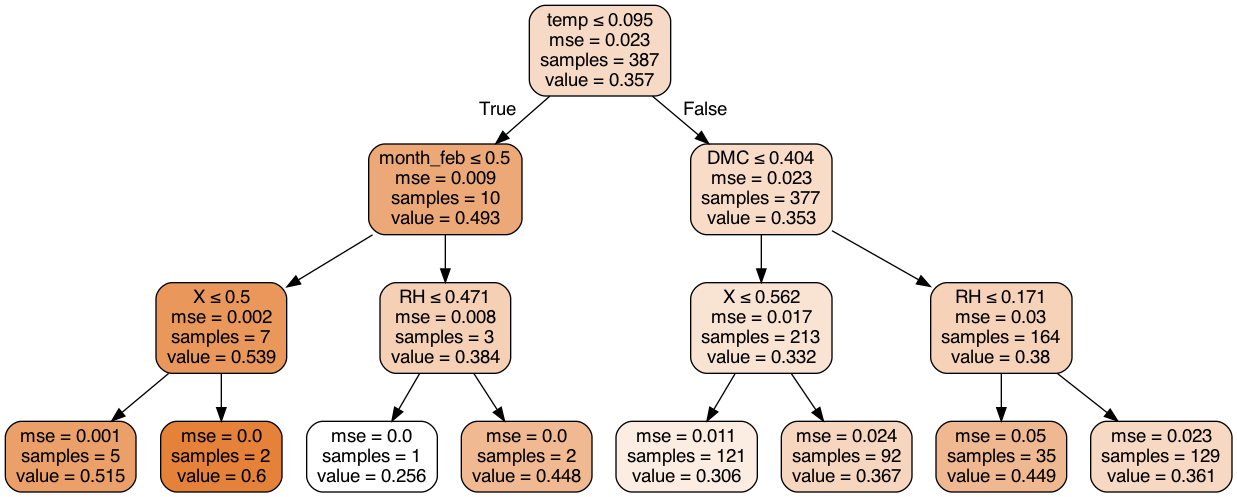

In [53]:
Image(get_png_tree(tree, list(data.columns)), width='80%')

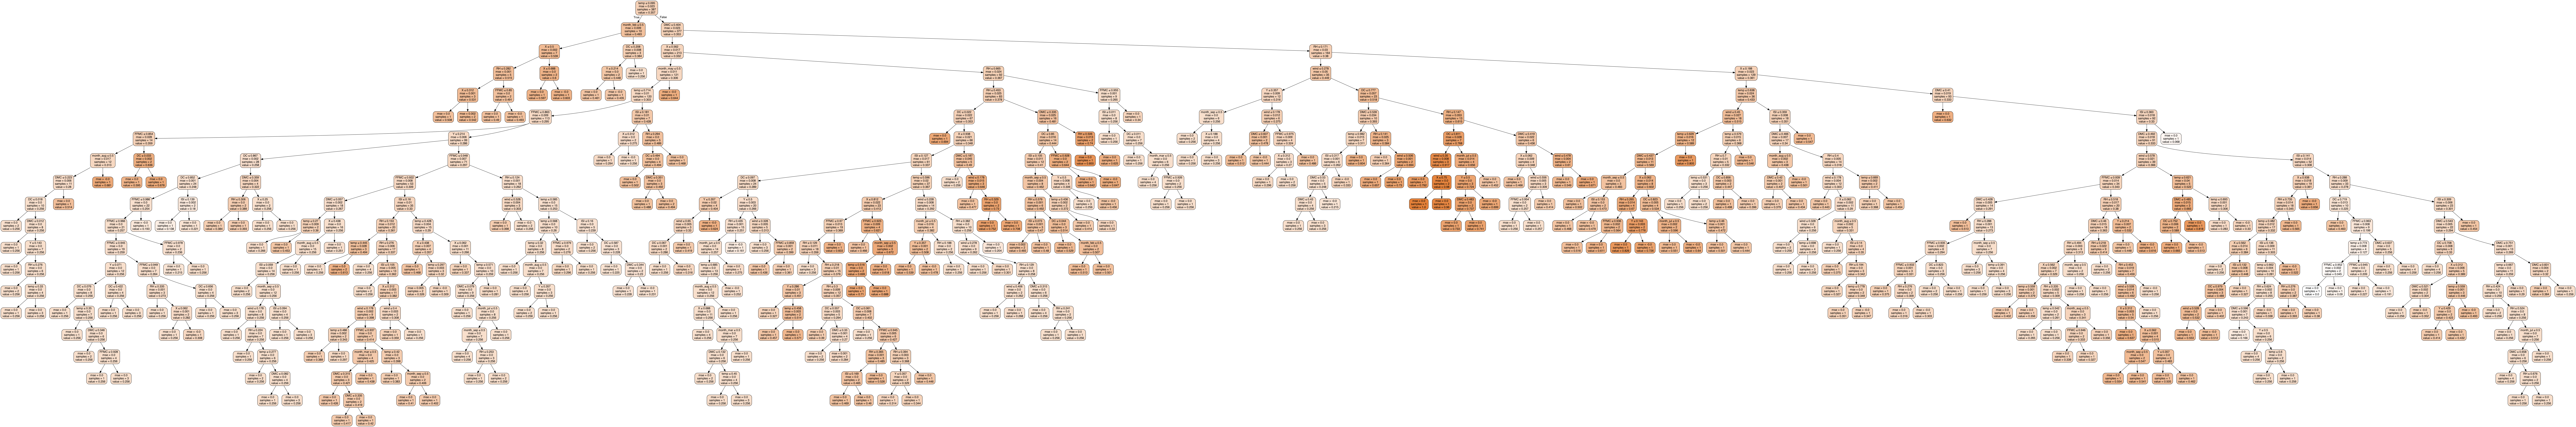

In [55]:
Image(get_png_tree(tree, list(data.columns)), width='80%')

Важность признаков

In [78]:
list(zip(data.columns.values, reg.feature_importances_))

[('X', 0.11962396491378928),
 ('Y', 0.02535962815547029),
 ('FFMC', 0.06728922635186531),
 ('DMC', 0.14492881433379842),
 ('DC', 0.10073643212238438),
 ('ISI', 0.06540364907304803),
 ('temp', 0.13889792174323612),
 ('RH', 0.1764045149684358),
 ('wind', 0.10854263319988743),
 ('rain', 0.0),
 ('month_aug', 0.017805826958772974),
 ('month_dec', 0.0),
 ('month_feb', 0.005605071781424671),
 ('month_jan', 0.0),
 ('month_jul', 0.013616566090833787),
 ('month_jun', 3.6432555012180596e-05),
 ('month_mar', 2.4609083721017645e-05),
 ('month_may', 0.012789803104703892),
 ('month_nov', 0.0),
 ('month_oct', 0.0),
 ('month_sep', 0.0029349055636165014)]

In [79]:
from operator import itemgetter

list_to_sort = list(zip(data.columns.values, reg.feature_importances_))
sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
labels = [x for x,_ in sorted_list]

In [80]:
labels

['RH',
 'DMC',
 'temp',
 'X',
 'wind',
 'DC',
 'FFMC',
 'ISI',
 'Y',
 'month_aug',
 'month_jul',
 'month_may',
 'month_feb',
 'month_sep',
 'month_jun',
 'month_mar',
 'rain',
 'month_dec',
 'month_jan',
 'month_nov',
 'month_oct']

In [81]:
mae_list = []

reg = dtr(random_state = 42)
for i in range(1, len(labels)+1):
    reg.fit(X_train[labels[0:i]], y_train)
    y_pred_tree2 = reg.predict(X_test[labels[0:i]])
    
    temp_mae = mae(y_pred_tree2, y_test)
    mae_list.append(temp_mae)

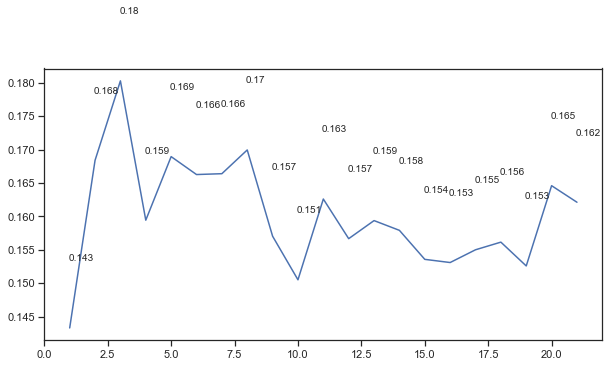

In [82]:
plt.subplots(figsize=(10,5))
plt.plot(range(1, len(labels)+1), mae_list)
for a,b in zip(range(1, len(labels)+1), mae_list):
    plt.text(a-0.05, b+0.01, str(round(b,3)))
plt.show()

In [83]:
reg = dtr(random_state = 42)

reg.fit(X_train[labels[0:10]], y_train)
y_pred_tree2 = reg.predict(X_test[labels[0:10]])

In [85]:
RMSE2 = mean_squared_error(y_test, y_pred_tree2, squared=False)
MAE2 = mean_absolute_error(y_test, y_pred_tree2)
R2_Score2 = r2_score(y_test, y_pred_tree2)
MedAE2 = median_absolute_error(y_test, y_pred_tree2)

print('RMSE =', RMSE2)
print('MAE =', MAE2)
print('R2 Score =', R2_Score2) # 1 - лучшее
print ("Median AE =", MedAE2) # 0 - лучшее

RMSE = 0.21189991259028265
MAE = 0.1505080333090303
R2 Score = -0.9518338334881249
Median AE = 0.11319229504952785


Результат немного улучшился

## Сравнение качества полученных моделей

In [65]:
clas_metrics = metrics.df['metric'].unique()
clas_metrics

array(['RMSE', 'MAE', 'R2 Score', 'Median AE'], dtype=object)

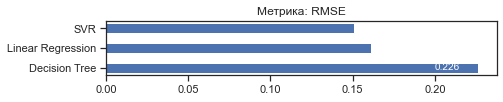

In [66]:
metrics.plot('Метрика: ' + 'RMSE', 'RMSE', ascending=False, figsize=(7, 1))

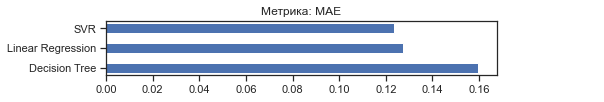

In [67]:
metrics.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 1))

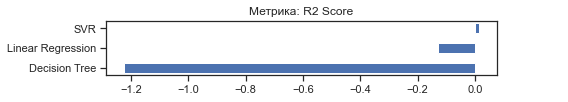

In [68]:
metrics.plot('Метрика: ' + 'R2 Score', 'R2 Score', ascending=True, figsize=(7, 1))

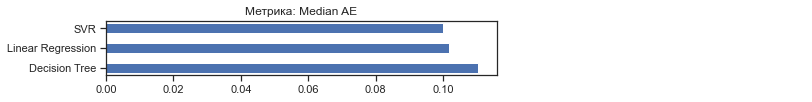

In [69]:
metrics.plot('Метрика: ' + 'Median AE', 'Median AE', ascending=False, figsize=(7, 1))

Лучшей оказалась модель SVR

# Лабораторная №5

#### Задание:

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите две ансамблевые модели. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

## Random Forest

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [71]:
rand_tree = RandomForestRegressor(n_estimators=15, oob_score=True, random_state=10)
rand_tree.fit(X_train, y_train)

RandomForestRegressor(n_estimators=15, oob_score=True, random_state=10)

In [72]:
rand_prediction = rand_tree.predict(X_test)

In [73]:
print('mean absolute error =', mean_absolute_error(y_test, rand_prediction))

mean absolute error = 0.1337298940909599


Попробуем ещё сверхслучайные деревья

In [56]:
extra_tree = ExtraTreesRegressor(random_state=1)
extra_tree.fit(X_train, y_train)

ExtraTreesRegressor(random_state=1)

In [58]:
extra_prediction = extra_tree.predict(X_test)

In [59]:
print('mean absolute error =', mean_absolute_error(y_test, extra_prediction))

RMSE = 0.16755347094135065
MAE = 0.1298180118270038
R2 Score = -0.22036050645294725
Median AE = 0.09762973648388157


## Stacking and blending 

In [23]:
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

In [24]:
dataset = Dataset(X_train, y_train, X_test)

model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')
model_svr = Regressor(dataset=dataset, estimator=SVR, parameters={'kernel': 'rbf', 'gamma': 0.001, 'C': 1000.0}, name = 'svr')

model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')

In [25]:
pipeline = ModelsPipeline(model_tree, model_lr, model_svr, model_rf)
stack_ds = pipeline.stack(k=10, seed=1)

stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=r2_score)

Metric: r2_score
Folds accuracy: [0.010420136570665983, 0.02150810563675476, 0.06022069456112977, 0.005333004143127651, -0.03833600005518689, -0.029089502707541737, 0.04405386972324965, -0.15318300396793982, 0.006223800625557274, -0.16595730572483425]
Mean accuracy: -0.02388062011950176
Standard Deviation: 0.07336586256280246
Variance: 0.005382549789584019


In [3]:
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [16]:
gb_score = reg.score(X_test, y_test)    #R2
gb_score

-0.19415976141010693

In [18]:
boost_prediction = reg.predict(X_test)

In [19]:
print('mean absolute error =', mean_absolute_error(y_test, boost_prediction))

mean absolute error = 0.1328153489717824


## Сравнение качества полученных моделей

In [22]:
array_labels = ['Gradient Boosting', 'Random Forest','Stacking and blending']
array_mae = [0.1328153489717824, 0.1298180118270038, 0.12339397515515596]

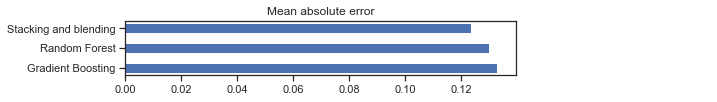

In [23]:
vis_models_quality(array_mae, array_labels, 'Mean absolute error', figsize=(7, 1))

Модель стекинга и блендинга показала лучшие метрики